# <center> <font color="#0496D9"> ChIP-seq project </center>

#### <b><ins> <font color="#069619"> PROJECT DATA AND SUMMARY</ins></b>
1. Purpose of study
    - This project aims to recreate results from the paper by Paul et al. PDR1 overexpression caused by gain of function mutations in the PDR1 promoter underpins azole-resistance in candida glabrata. This study objects to identify genes regulated by the PDR1 transcription factor and the consensus sequence of the TF binding site common to all PDR1 binding sites.


2. Data files
    - Two paired-end in sync compressed FASTQ files - chip_R1.fastq.gz and chip_R2.fastq.gz
    - Each read contains: read ID, DNA sequence, read ID, quality string
    - File size: 53M    
    - 1062114 sequences 51bp in length in each file
    

4. Quality encoding
    - Encodes sanger/illumina 1.9, indicating Phred +33 was used
    - Illumina adapters used to obtain data

#### <ins><font color="#069619"> QUALITY ASSESSMENT </ins>
The command `fastqc *fastq.gz` applied quality control to chip_R1.fastq.gz and chip_R2.fastq.gz. An [HTML assessment report](chip_R1_fastqc.html) was generated for each. Problematic areas for both were per tile sequence quality, per sequence GC content, and adapter content.

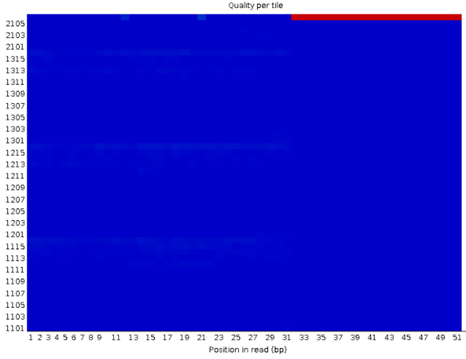 
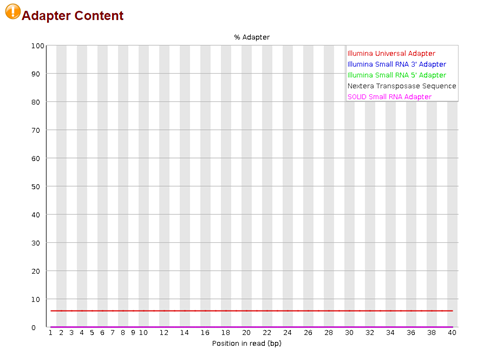

Towards the end of sequences, qualities may begin to drop off. As the low-quality scores were localised to one region in both files, it is likely that there was debris or smudges on the flow cell. Applying quality trimming can improve mapping rates but can lead to information loss and short reads.

Parts of adapters used to obtain the reads remain in some sequences. An orange warning indicates adapter sequences are present in over 5% of reads. As these are not found in Candida glabrata's genome, they need to be removed prior to mapping, or problems may arise with mapping accuracy. Adapter trimming improves mapping but can lead to short reads and multimaps if the unique origin location is lost.
    
The `trim_galore` command carries out quality and adapter trimming. The Illumina adapter was identified and used to trim the sequences.  

Fastqc was run on the trimmed files to generate a new [HTML file](chip_R1_trimmed_fastqc.html). Although previous warnings were resolved, a different number of reads remain in both files. Trimming removed 2.5% of reads from chip_R1.fastq.gz and 4.6% from chip_R2.fastq.gz. If one read is removed but not the other cuasing files to become out of sync, the second row can pair with the first despite coming from different areas of the chromosome. The mapper will not know there is a mismatch in synchronisation. Resyncing was achieved using the command `trim_galore --paired`. Both files now have the same number of reads. Fastqc was run on the paired, trimmed files to generate the final [HTML file](chip_R1_val_1_fastqc.html). 

#### <b><ins><font color="#069619">  READ MAPPING</ins></b>
Prior to mapping, chromosome names were reheadered in standard format, i.e. ChrA --> chrA, in a [python notebook](reheader_chromosomes.ipynb).

Mapping took place using bowtie2. An index was built from the reference genome "C_glabrata.fa" using the command `bowtie2-build C_glabrata.fa C_glabrata`. An index is necessary to keep bowtie's memory footprint small, allowing it to map millions of reads at high speed. 

Short read mapping with bowtie2 requires another command. 

| Command section | Meaning |
| --- | --- |
| **bowtie2** | Short read mapping tool |
| **-x C_glabrata** | Reference genome |
| **-1 chip_R1_val_1.fq.gz** | Input file – trimmed & paired file |
| **-2 chip_R2_val_2.fq.gz** | Input file – trimmed & paired file |
| **--mm** | Memory sharing – more efficient for multiple users |
| **out.sam** | Output file |

This command uses the trimmed, paired versions of the R1 and R2 files to achieve high accuracy mapping.
    
This command's output shows an overall 83.38% alignment rate, meaning 83.4% of the reads were mapped against the reference genome. To improve this, the `very sensitive local ` pre-set was employed in bowtie2. The default choice is sensitive end to end alignment. As the sequences have already been trimmed, local alignment may not seem necessary as it performs soft-clipping, removing some poor-quality bases. Despite this, it had the highest overall alignment rate - improving the rate to 83.44%. The slight improvement may indicate that a few bases were trimmed which remained after original hard trimming.

#### <b><ins><font color="#069619"> VISUALISATION</ins></b>
Bowtie2 produces a SAM file; however, for visualisation with IGV (integrated genome viewer), it needs to be compressed into BAM format. BAM files are too detailed for a complete chromosome view and need to be converted to bigwig format. These conversions, as well as the original mapping were carried out simultaneously in the [bowtie_mapping.ipynb](bowtie_mapping.ipynb). 

To create a file with gene information to use in IGV, a [python notebook](annotation2gff.ipynb) was employed creating a chromosomal features file “C_glabrata.gff3.”
    
By downloading the reference C_glabrata.fa file, chromosomal features, and the bam and BigWig file, it is possible to upload them into IGV using the index chip.bam.bai.
    
As seen in the image below, many peaks correlate with genes however, reads should accumulate where transcription binding activity takes place, i.e. promoters as expected from a ChIPSeq experiment.
    
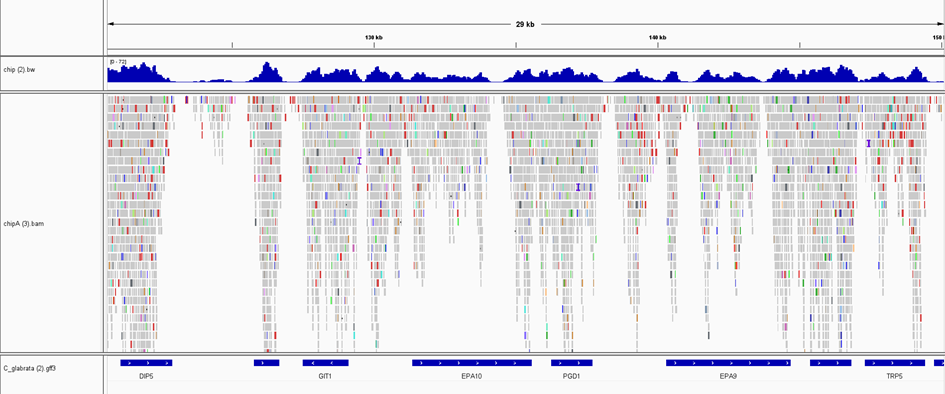

Many peaks shown are background noise - actual peaks need to be determined using a control.    
    
Control files ctrl_R1.fastq.gz and ctrl_R2.fastq.gz were processed in [processing_control_data.ipynb](processing_control_data.ipynb). The same steps were followed to generate a bam, index, and bigwig file to view in IGV.
    
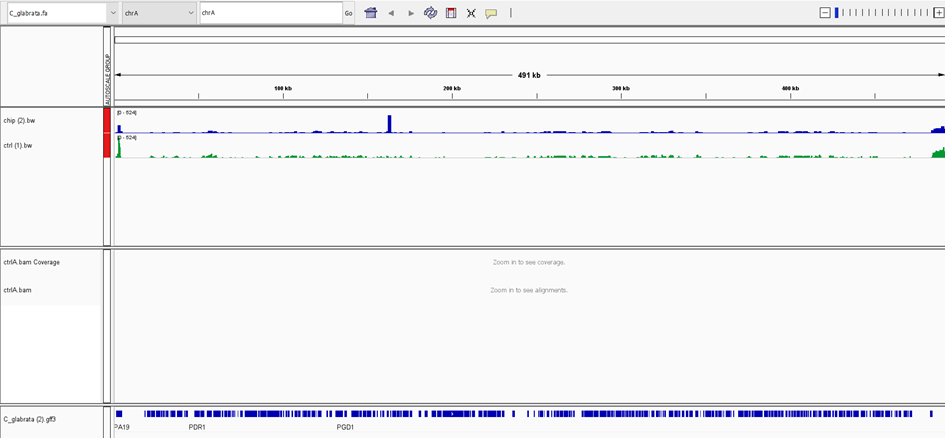
    
As seen above, most peaks are visible in the control and ChIPSeq data. From this, peaks with no match in the control can be elucidated, indicating biological significance.
    
The most significant peak in chromosome A was found at ~163,000bp and as shown below, no matching peak is visible in the control data. This peak is found before the gene CAGL0A01650g indicating that it is at the promoter. This gene codes for a putative protein upregulated in azole-resistant strains. As the antibody was raised against PDR1, this peak suggests azole-resistant genes are influenced by the PDR1 transcription factor.

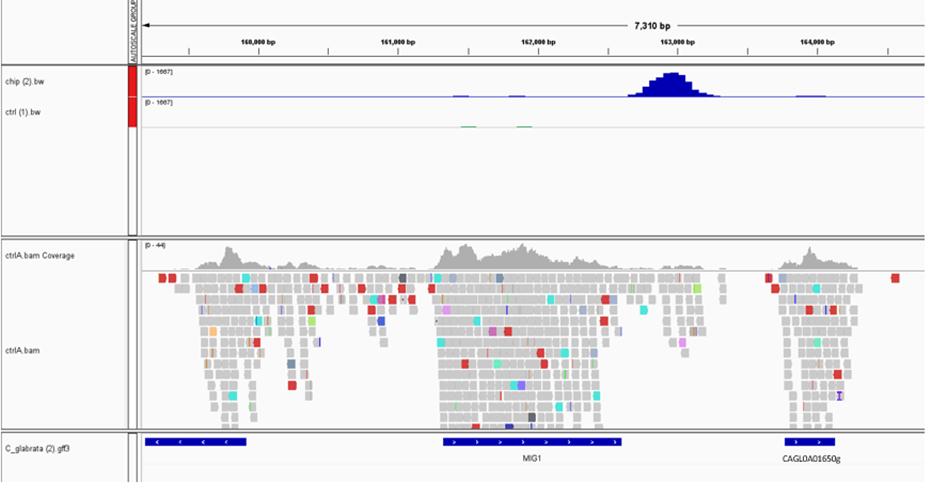

#### <b> <ins> <font color="#069619"> PEAK CALLING / MOTIF DETECTION </ins> </b>
Gem is a peak calling and motif discovery system used for ChIPSeq data and was used in this study in [peak_and_motif_finding_with_GEM.ipynb](peak_and_motif_finding_with_GEM.ipynb). 

C_glabrata.fa was first split into individual chromosomes as this parameter is required by GEM. It also requires a file of the sizes of each chromosome. These steps were completed in [split_chrom.ipynb](split_chrom.ipynb).
    
GEM results can be compared to peaks from IGV with the option `--outBED`. A .BED file was loaded into IGV to view GEM’s top peaks alongside original mapping. Results are stored in the folder out6.

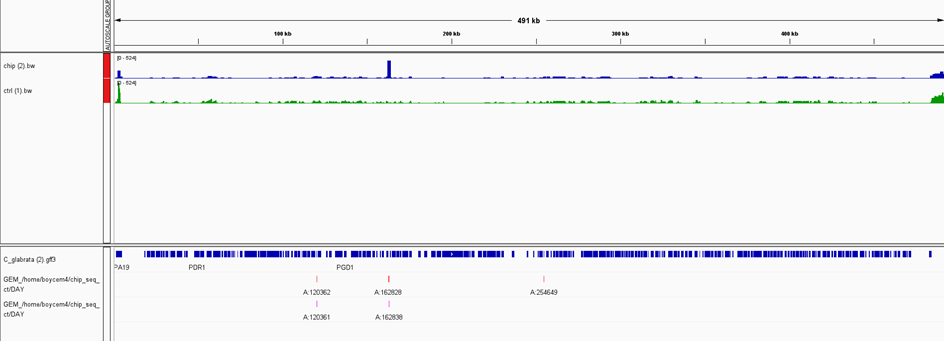
    
Similar peaks are present in the chipseq data and GEM files. The creation of the BED file took into account the control data, so no false positives were present.
    
The consensus motif is stored in a .htm. In order to view these images, this file must be converted to HTML using the command `gem_results_conversion.pl out1`. The potential consensus motif can now be obtained from the [HTML file](https://jupyterhub.gen.tcd.ie/jupyter/hub/user-redirect/lab/tree/chip_seq_project/all/out1/out1.results.html).
    
<center>
<figure>
    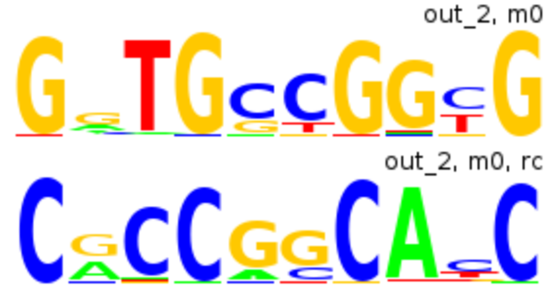
    <figcaption>Motif from GEM.</figcaption>
</figure>
<figure>
    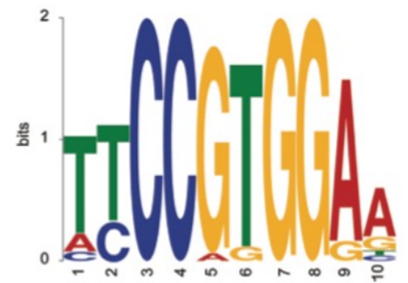
    <figcaption>Motif from Paul et al.</figcaption>
</figure>
</center>

This motif has minimal similarity to Paul et al. as only a subset of the genome, chromosome A, was analysed. There was not enough coverage to devise a similar motif and there is a lot of background noise in the data, obscuring the actual results.  
    
To alleviate this, GEM was run on entire genome with a control. Following the same steps, a new motif was produced in a [HTML file](https://jupyterhub.gen.tcd.ie/jupyter/hub/user-redirect/lab/tree/chip_seq_project/all/out3/out3.results.html). 
    
<center>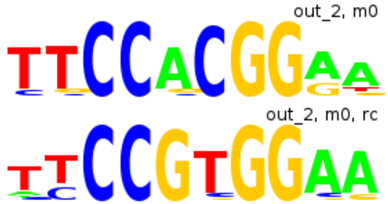</center>

These motifs closely follow consensus sequence of the original paper. It is evident that accuracy can be improved by removing background noise and increasing coverage.

#### <b><ins> <font color="#069619"> LIST OF GENES </ins></b>
The list of genome wide peaks generated by GEM in the file out6.GEM_events.txt was mapped against genes in Candida glabrata in [intersect_peaks_and_genes.ipynb](intersect_peaks_and_genes.ipynb). The code included peaks whose summit occurred in promoters up to 1000bp away from the beginning of genes. The list was stored in [genes_with_peaks3.csv](genes_with_peaks3.csv). 
    
Many of these peaks aligned with genes relating to azole resistance alluding that the analysis was of good quality. However, from analysis of [bitwise flags](flag_from_bam.ipynb) and [mapping qualities](mapq_from_bam.ipynb) in chip.bam, it is clear that many alignments are not high-quality. The most common flags were 83 and 163. These flags are mates indicating properly mapped read pairs on the reverse strand. The next two flags, 99 and 147, are a correctly mapped pair on the forward strand. All other flags indicate incorrectly mapped reads. The mapq analysis indicated that many reads are low-quality. The lower the score, the more likely the read can map to other locations. It is necessary to remove these to increase mapping accuracy. A cut-off point of 30 was decided upon to maintain a high quality and high coverage.
    
Samtools was used to trim chip.bam and ctrl.bam.
    
| Command section | Meaning |
| --- | --- |
| **Samtools view -b** | tool allows viewing and processing of BAM files |
| **-q 30** | skip alignments with MAPQ smaller than 30 |
| **Chip.bam** | input file |
| **>  chip_q30.bam** | redirect the output into a new file  |
    
Peak_and_motif_finding_with_GEM.ipynb was run with the new files and a minimum and maximum motif size to allow for more flexibility to detect more reliable motifs. Results were stored in out7. The same steps were followed to generate a [new gene list](genes_with_peaks.csv).
        
The BED files were uploaded to IGV, as indicated below by the pink and purple bars.  
    
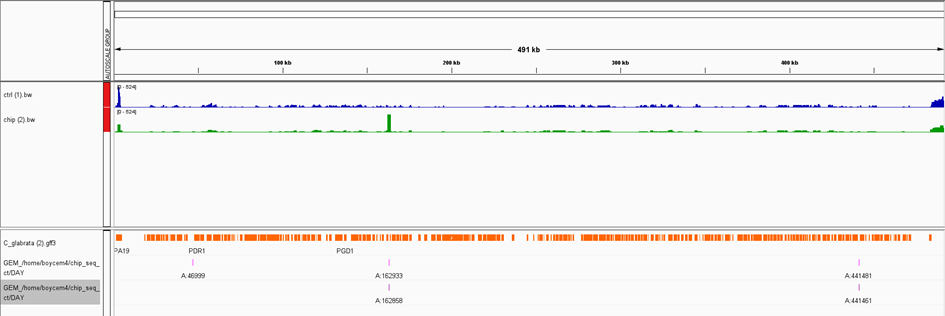
    
Many of the same peaks from the table are seen in IGV.

#### <b><ins> <font color="#069619">  DISCUSSION </ins></b>
This results from this study closely follow the original published paper.
    
Firstly, the potential consensus motif for the PDR1 binding site matched precisely to that of the original paper. GEM analysis on the whole genome with a control was observably accurate. Similar trimming and parameters must have been used by Paul et al. 
    
<center>
<figure>
    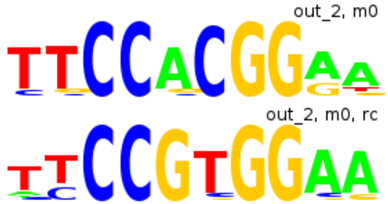
    <figcaption>Motif from GEM.</figcaption>
</figure>
<figure>
    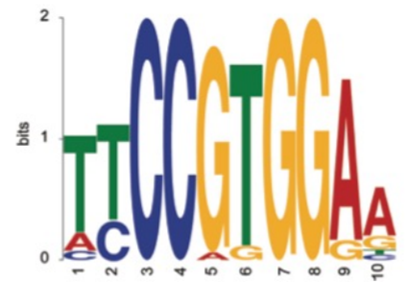
    <figcaption>Motif from Paul et al.</figcaption>
</figure>
</center>
    
Secondly, many peaks matched those from the original paper. Below is an image from the original paper with peaks at the promoter regions of CDR2, PDR1 and VPS14. These peaks can be mirrored in this study, proving mapping was effective in elucidating accurate results.  
    
<center>
<figure>
    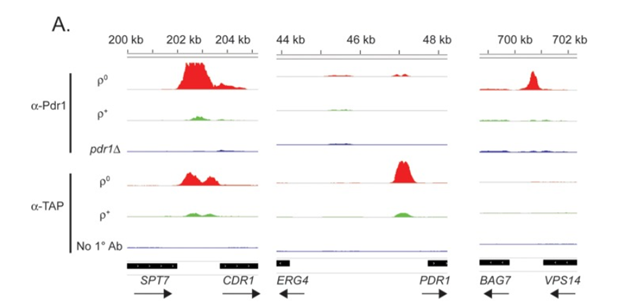
    <figcaption>Peaks from Paul et al.</figcaption>
</figure>
<figure>
    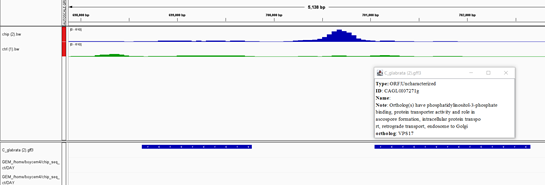
    <figcaption>BAG7 from project.</figcaption>
</figure>
<figure>
    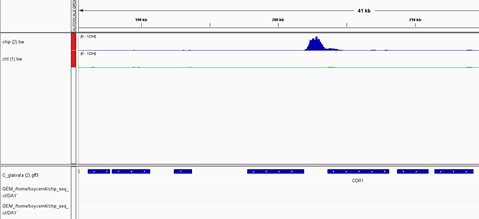
    <figcaption>CDR1 from project.</figcaption>
</figure>
<figure>
    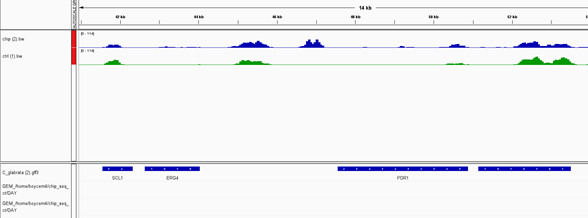
    <figcaption>PDR1 from project.</figcaption>
</figure>    
</center>    
    
Lastly, the gene targets obtained was similar, with 22 out of 25 of the genes from the original paper detected. However, 15 others were also pulled out in this study possibly due to different parameters/quality scores/trimming levels. In attempts to get a more accurate list, PCR duplicates were removed using the Samtools option  `rdump`; however, essential genes such as PDR1 were removed from the list, so these files were not used. 

<center>
<figure>
    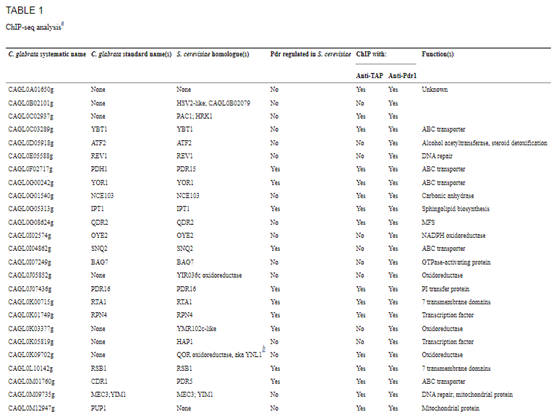
    <figcaption>Gene list from Paul et al.</figcaption>
</figure>
<figure>
    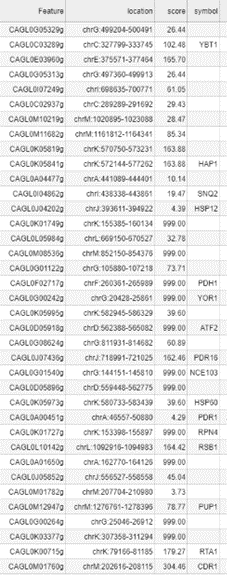
    <figcaption>Gene list from project.</figcaption>
</figure>
</center>    
    
Overall, the project successfully produced similar results to the original paper. Discrepancies between the two were likely caused by different parameters and trimming or by different/more advanced techniques. 

##### <center> <font color="#9D06FE">  WORD COUNT </center>

In [65]:
import io
from IPython.nbformat import current


file = '19333965_project_report.ipynb'

with io.open(file, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split())
print(word_count)

1863


In [63]:
#NB - this word count includes html tags, images, captions, tables, and hyperlinks - 1566 without